# 📊 主成分分析 (PCA) - 降维技术

> 最经典的降维算法 - 将高维数据投影到低维空间

---

## 📚 学习目标

完成本Notebook后，你将能够：

- ✅ 理解PCA的核心原理和数学基础
- ✅ 从零实现PCA算法（NumPy版）
- ✅ 使用Scikit-learn的PCA实现
- ✅ 使用解释方差比确定最优成分数
- ✅ 可视化高维数据的降维结果
- ✅ 了解PCA的应用场景（数据可视化、降噪、图像压缩）
- ✅ 理解PCA的优缺点和适用场景

---

## 1. PCA 原理

### 1.1 什么是降维？

**降维 (Dimensionality Reduction)** 是将高维数据转换到低维空间的过程，同时尽可能保留原始数据的重要信息。

**为什么需要降维？**
- 🎯 **可视化**：将高维数据降至2D/3D便于可视化
- ⚡ **加速训练**：减少特征数量，降低计算复杂度
- 🧹 **去除噪声**：过滤掉不重要的特征
- 💾 **数据压缩**：减少存储空间
- 🔍 **避免维度灾难**：高维空间中数据稀疏，影响算法性能

### 1.2 PCA核心思想

**主成分分析 (Principal Component Analysis)** 通过线性变换找到数据的主要方向（主成分），这些方向捕获了数据的最大方差。

**关键概念**：
1. **第一主成分 (PC1)**：数据方差最大的方向
2. **第二主成分 (PC2)**：与PC1正交且方差第二大的方向
3. **第k主成分 (PCk)**：与前k-1个主成分正交且方差第k大的方向

### 1.3 数学原理

**步骤1：数据中心化**
$$X_{centered} = X - \mu$$

其中：
- $\mu$ (mu)：均值向量 (mean)

**步骤2：计算协方差矩阵**
$$C = \frac{1}{n-1} X^T X$$

其中：
- $n$：样本数量 (number of samples)
- 使用 $n-1$ 而非 $n$ 是贝塞尔校正 (Bessel's correction)，得到无偏估计

**步骤3：特征值分解**
$$C = V \Lambda V^T$$

其中：
- $V$：特征向量矩阵（主成分方向）
- $\Lambda$ (Lambda)：特征值对角矩阵（方差大小）

**步骤4：选择k个主成分**
- 选择前k个最大特征值对应的特征向量

**步骤5：投影数据**
$$X_{reduced} = X_{centered} \cdot V_k$$

其中：
- $k$：要保留的主成分数量
- $V_k$：前 k 个主成分构成的矩阵

### 1.4 直观理解

```
原始数据 (3D):          PCA投影 (2D):
    ↑                      ↑ PC2
    │  •  •                │  •  •
    │ •  •                 │ •  •
    • •                    • • ─────→ PC1
    
去除最小方差方向 → 保留主要信息 → 降维完成
```

---

## 2. 环境准备

In [4]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# 数据生成和预处理
from sklearn.datasets import make_blobs, load_iris, load_digits
from sklearn.preprocessing import StandardScaler

# PCA相关
from sklearn.decomposition import PCA

# 聚类算法
from sklearn.cluster import KMeans

# 评估指标
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = [
        'Arial Unicode MS',  # macOS通用
        'PingFang SC',       # macOS系统字体
        'STHeiti',           # 华文黑体
        'Heiti TC',          # 黑体-繁
        'SimHei',            # 黑体
    ]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 设置随机种子
np.random.seed(42)

print("✅ 环境准备完成！")

✅ 环境准备完成！


## 3. 生成模拟数据

数据形状: (300, 3)
数据维度: 3D

各维度的方差:
  维度 1: 2.3877
  维度 2: 1.6827
  维度 3: 0.4207


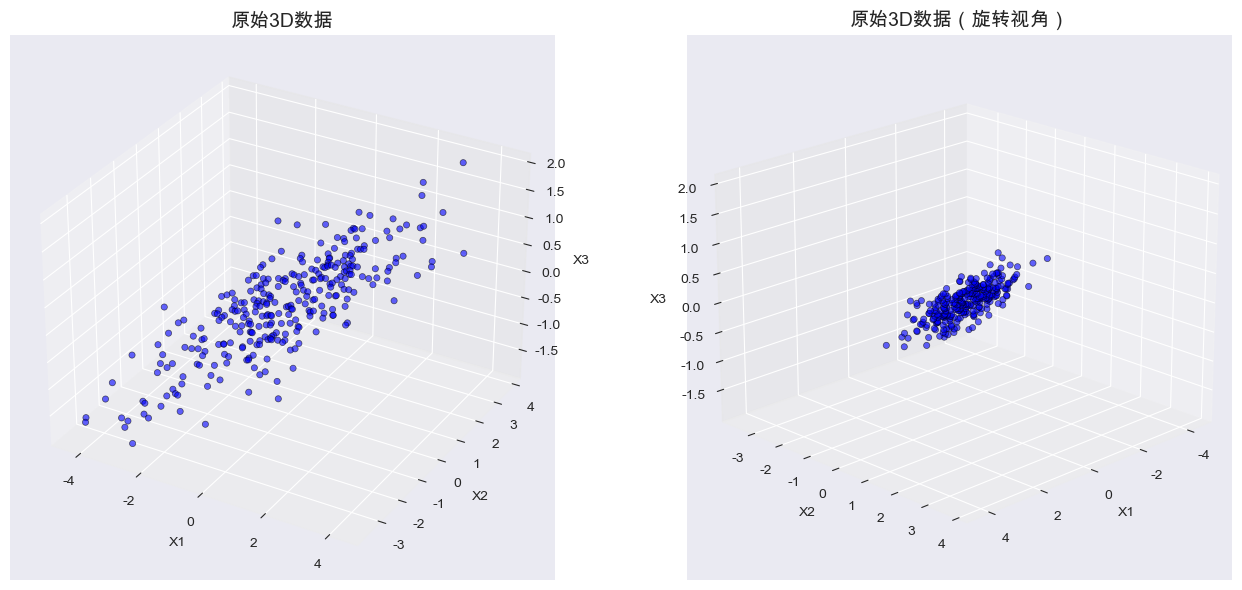


💡 观察：数据在某些方向上的分散程度不同，这正是PCA要利用的特性！


In [3]:
# 生成3D数据，演示降维到2D
np.random.seed(42)

# 创建相关的3D数据
mean = [0, 0, 0]
cov = [[3, 2, 1],   # 第一个方向方差大
       [2, 2, 1],   
       [1, 1, 0.5]] # 第三个方向方差小

X_3d = np.random.multivariate_normal(mean, cov, 300)

print(f"数据形状: {X_3d.shape}")
print(f"数据维度: {X_3d.shape[1]}D")
print(f"\n各维度的方差:")
for i in range(X_3d.shape[1]):
    print(f"  维度 {i+1}: {X_3d[:, i].var():.4f}")

# 3D可视化原始数据
fig = plt.figure(figsize=(14, 6))

# 3D视图
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c='blue', alpha=0.6, edgecolors='black', linewidth=0.5)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('X3')
ax1.set_title('原始3D数据', fontsize=14)

# 从不同角度看
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c='blue', alpha=0.6, edgecolors='black', linewidth=0.5)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('X3')
ax2.set_title('原始3D数据（旋转视角）', fontsize=14)
ax2.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

print("\n💡 观察：数据在某些方向上的分散程度不同，这正是PCA要利用的特性！")

## 4. 从零实现 PCA 算法 ⭐

这是理解PCA原理的最佳方式！

In [5]:
class PCAFromScratch:
    """
    从零实现的PCA算法
    
    Parameters:
    -----------
    n_components : int
        要保留的主成分数量
    """
    
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.components_ = None          # 主成分（特征向量）
        self.explained_variance_ = None  # 解释方差（特征值）
        self.explained_variance_ratio_ = None  # 解释方差比
        self.mean_ = None                # 数据均值
        
    def fit(self, X):
        """
        训练PCA模型
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            训练数据
        """
        # 步骤1: 数据中心化（减去均值）
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_
        
        # 步骤2: 计算协方差矩阵
        # Cov = (X^T @ X) / (n-1)
        n_samples = X.shape[0]
        cov_matrix = (X_centered.T @ X_centered) / (n_samples - 1)
        
        # 步骤3: 特征值分解（Eigenvalue Decomposition）
        # 
        # 这是PCA的核心步骤！将协方差矩阵分解为特征值和特征向量
        #
        # 📌 什么是特征值和特征向量？
        # - 特征向量 (eigenvector)：数据分散的"方向"（主成分的方向）
        # - 特征值 (eigenvalue)：该方向上的"方差大小"（该方向的重要程度）
        #
        # 🎯 直观理解：
        # 想象数据是一个椭圆形的点云：
        # - 特征向量 = 椭圆的长轴和短轴方向
        # - 特征值 = 每个轴的长度（数据在该方向的分散程度）
        # - 特征值越大 → 该方向越重要 → 包含更多信息
        #
        # 📊 返回值说明：
        # - eigenvalues: shape (n_features,) - 每个方向的方差
        # - eigenvectors: shape (n_features, n_features) - 每列是一个方向向量
        #
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        
        # 步骤4: 按特征值大小排序
        # 获取排序索引（从大到小）
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # 步骤5: 选择前k个主成分
        #
        # ⚠️ 关键理解：numpy的特征向量存储方式
        #
        # 📌 eigenvectors 的存储格式：
        # - np.linalg.eig() 返回的 eigenvectors 形状是 (n_features, n_features)
        # - **重要**：每一列（不是每一行）是一个特征向量！
        # - eigenvectors[:, 0] = 第一个特征向量（PC1）
        # - eigenvectors[:, 1] = 第二个特征向量（PC2）
        # - eigenvectors[:, k] = 第k+1个特征向量
        #
        # 🔍 代码分解：
        #
        # 1️⃣ eigenvectors[:, :self.n_components]
        #    - 选择前 k 列（前 k 个主成分）
        #    - 形状：(n_features, k)
        #    - 例如：3维数据选2个主成分 → (3, 2)
        #    - 这对应数学公式中的 V_k
        #
        # 2️⃣ .T (转置)
        #    - 为什么要转置？sklearn的存储惯例！
        #    - sklearn的 components_ 形状应该是 (k, n_features)
        #    - 即：每一行是一个主成分
        #    - 转置后形状：(k, n_features)
        #    - 例如：(3, 2) → (2, 3)
        #
        # 📐 形状变化示例（假设3D数据降到2D）：
        #    eigenvectors: (3, 3)              # 3个特征，3个特征向量
        #         ↓ [:, :2]
        #    (3, 2)                            # 选择前2个特征向量
        #         ↓ .T
        #    components_: (2, 3)               # 2个主成分，每个是3维向量
        #
        # 🔗 与数学公式的对应：
        #    公式：X_reduced = X_centered · V_k
        #    - V_k 是 (n_features, k) 的矩阵
        #    - 但sklearn存储为 (k, n_features)，所以投影时需要转置回来
        #    - 实际计算：X_reduced = X_centered @ components_.T
        #
        self.components_ = eigenvectors[:, :self.n_components].T
        
        # 选择前k个特征值（每个主成分的方差）
        # .real: 取实部，避免数值误差产生的微小虚部
        # （理论上实对称矩阵的特征值应该都是实数）
        self.explained_variance_ = eigenvalues[:self.n_components].real
        
        # 计算解释方差比
        total_variance = np.sum(eigenvalues.real)
        self.explained_variance_ratio_ = self.explained_variance_ / total_variance
        
        return self
    
    def transform(self, X):
        """
        将数据投影到主成分空间
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            要转换的数据
            
        Returns:
        --------
        X_transformed : array, shape (n_samples, n_components)
            降维后的数据
        """
        # 中心化
        X_centered = X - self.mean_
        
        # 投影到主成分空间
        # X_reduced = X_centered @ components^T
        X_transformed = X_centered @ self.components_.T
        
        return X_transformed
    
    def fit_transform(self, X):
        """训练并转换数据"""
        self.fit(X)
        return self.transform(X)
    
    def inverse_transform(self, X_transformed):
        """
        从降维后的数据重构原始数据
        
        Parameters:
        -----------
        X_transformed : array-like, shape (n_samples, n_components)
            降维后的数据
            
        Returns:
        --------
        X_reconstructed : array, shape (n_samples, n_features)
            重构的数据
        """
        # X_reconstructed = X_reduced @ components + mean
        X_reconstructed = X_transformed @ self.components_ + self.mean_
        return X_reconstructed

print("✅ PCAFromScratch 类定义完成！")

✅ PCAFromScratch 类定义完成！


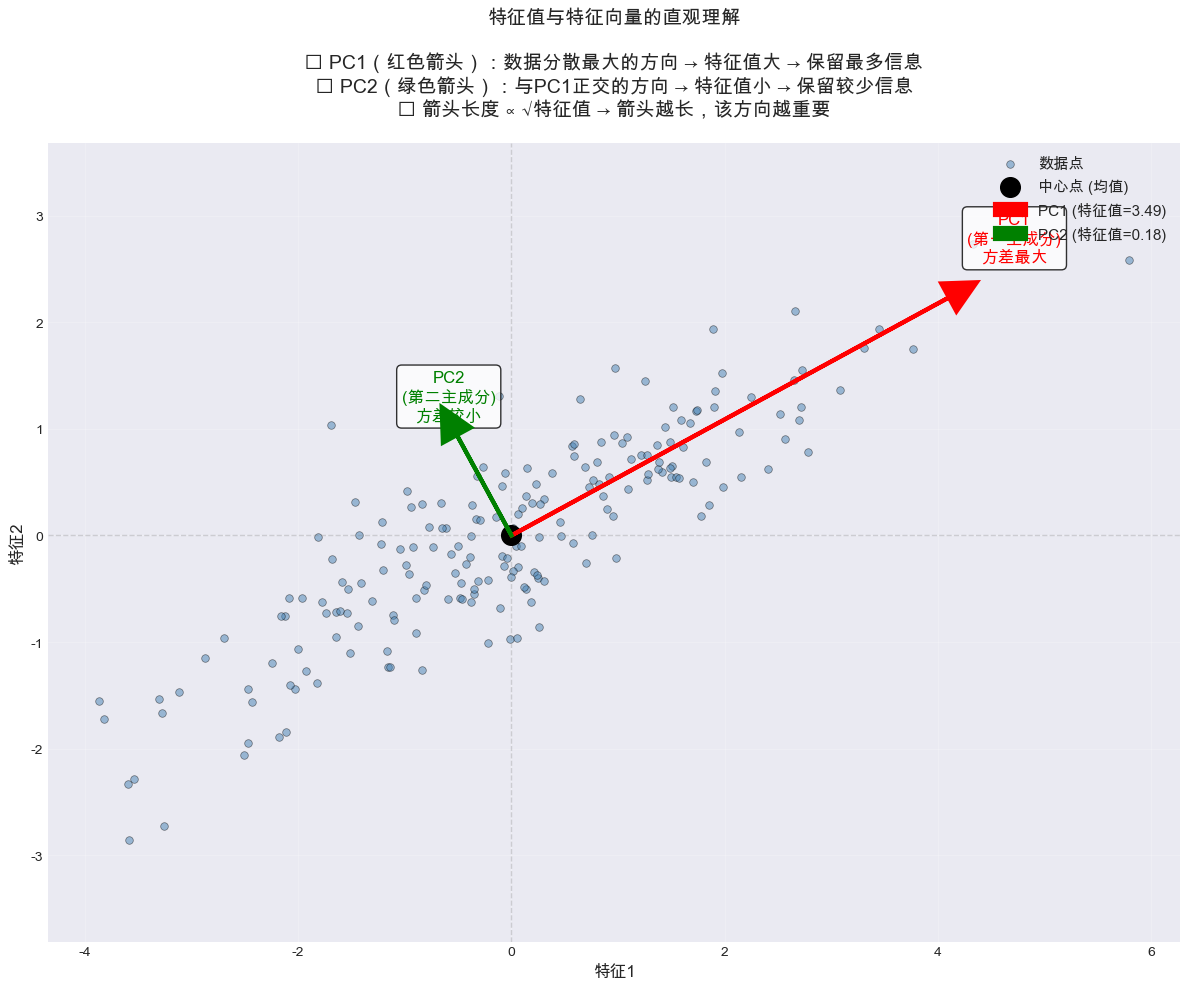

📊 特征值分解结果：

第一主成分 (PC1):
  • 特征值: 3.4887
  • 特征向量: [0.8784, 0.4779]
  • 解释方差比: 95.00%

第二主成分 (PC2):
  • 特征值: 0.1835
  • 特征向量: [-0.4779, 0.8784]
  • 解释方差比: 5.00%

💡 关键理解：
  • 特征值越大 → 该方向数据分散程度越大 → 包含信息越多
  • PC1的特征值(3.49) > PC2的特征值(0.18)
  • 所以降维时优先保留PC1方向！


In [6]:
# 生成2D椭圆形数据来演示特征值和特征向量
np.random.seed(42)

# 创建一个协方差矩阵，使得数据呈椭圆形分布
# 第一个方向方差大（长轴），第二个方向方差小（短轴）
mean_demo = [0, 0]
cov_demo = [[3.0, 1.5],   # 第一个方向方差=3，两个方向有正相关性
            [1.5, 1.0]]   # 第二个方向方差=1

# 生成200个样本点
X_demo = np.random.multivariate_normal(mean_demo, cov_demo, 200)

# 计算协方差矩阵
X_demo_centered = X_demo - X_demo.mean(axis=0)
cov_matrix_demo = (X_demo_centered.T @ X_demo_centered) / (len(X_demo) - 1)

# 特征值分解
eigenvalues_demo, eigenvectors_demo = np.linalg.eig(cov_matrix_demo)

# 按特征值大小排序
idx_demo = eigenvalues_demo.argsort()[::-1]
eigenvalues_demo = eigenvalues_demo[idx_demo]
eigenvectors_demo = eigenvectors_demo[:, idx_demo]

# 可视化
plt.figure(figsize=(12, 10))

# 绘制数据点（椭圆形分布）
plt.scatter(X_demo[:, 0], X_demo[:, 1], alpha=0.5, s=30, 
           c='steelblue', edgecolors='black', linewidth=0.5, label='数据点')

# 数据中心点
plt.scatter(0, 0, c='black', s=200, marker='o', zorder=10, label='中心点 (均值)')

# 绘制特征向量（主成分方向）
# 使用特征值的平方根来确定箭头长度，使其与数据的标准差成比例
scale = 2.5  # 缩放因子，使箭头更明显

# 第一主成分 (PC1) - 方差最大的方向
pc1 = eigenvectors_demo[:, 0] * np.sqrt(eigenvalues_demo[0]) * scale
plt.arrow(0, 0, pc1[0], pc1[1], 
         head_width=0.3, head_length=0.3, fc='red', ec='red', linewidth=3,
         label=f'PC1 (特征值={eigenvalues_demo[0]:.2f})', zorder=11)
plt.text(pc1[0]*1.15, pc1[1]*1.15, 'PC1\n(第一主成分)\n方差最大', 
        fontsize=12, fontweight='bold', color='red', ha='center',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 第二主成分 (PC2) - 方差第二大的方向
pc2 = eigenvectors_demo[:, 1] * np.sqrt(eigenvalues_demo[1]) * scale
plt.arrow(0, 0, pc2[0], pc2[1], 
         head_width=0.3, head_length=0.3, fc='green', ec='green', linewidth=3,
         label=f'PC2 (特征值={eigenvalues_demo[1]:.2f})', zorder=11)
plt.text(pc2[0]*1.15, pc2[1]*1.15, 'PC2\n(第二主成分)\n方差较小', 
        fontsize=12, fontweight='bold', color='green', ha='center',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 添加网格和坐标轴
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3, linewidth=1)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3, linewidth=1)
plt.grid(True, alpha=0.2)

# 设置坐标轴范围
plt.xlim(-8, 8)
plt.ylim(-6, 6)
plt.axis('equal')

# 标签和标题
plt.xlabel('特征1', fontsize=12)
plt.ylabel('特征2', fontsize=12)
plt.title('特征值与特征向量的直观理解\n\n' + 
         '🔴 PC1（红色箭头）：数据分散最大的方向 → 特征值大 → 保留最多信息\n' +
         '🟢 PC2（绿色箭头）：与PC1正交的方向 → 特征值小 → 保留较少信息\n' +
         '📏 箭头长度 ∝ √特征值 → 箭头越长，该方向越重要',
         fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

# 打印数值信息
print("="*60)
print("📊 特征值分解结果：")
print("="*60)
print(f"\n第一主成分 (PC1):")
print(f"  • 特征值: {eigenvalues_demo[0]:.4f}")
print(f"  • 特征向量: [{eigenvectors_demo[0, 0]:.4f}, {eigenvectors_demo[1, 0]:.4f}]")
print(f"  • 解释方差比: {eigenvalues_demo[0]/eigenvalues_demo.sum():.2%}")

print(f"\n第二主成分 (PC2):")
print(f"  • 特征值: {eigenvalues_demo[1]:.4f}")
print(f"  • 特征向量: [{eigenvectors_demo[0, 1]:.4f}, {eigenvectors_demo[1, 1]:.4f}]")
print(f"  • 解释方差比: {eigenvalues_demo[1]/eigenvalues_demo.sum():.2%}")

print(f"\n💡 关键理解：")
print(f"  • 特征值越大 → 该方向数据分散程度越大 → 包含信息越多")
print(f"  • PC1的特征值({eigenvalues_demo[0]:.2f}) > PC2的特征值({eigenvalues_demo[1]:.2f})")
print(f"  • 所以降维时优先保留PC1方向！")
print("="*60)

### 4.1 可视化理解：特征值与特征向量 🎯

在深入代码之前，让我们用一个直观的例子来理解特征值和特征向量的含义。

In [7]:
# 测试我们从零实现的PCA
pca_scratch = PCAFromScratch(n_components=2)
X_2d_scratch = pca_scratch.fit_transform(X_3d)

print(f"原始数据形状: {X_3d.shape}")
print(f"降维后形状: {X_2d_scratch.shape}")
print(f"\n主成分（特征向量）:")
print(pca_scratch.components_)
print(f"\n解释方差（特征值）: {pca_scratch.explained_variance_}")
print(f"\n解释方差比: {pca_scratch.explained_variance_ratio_}")
print(f"累积解释方差比: {pca_scratch.explained_variance_ratio_.sum():.4f}")
print(f"\n💡 前2个主成分保留了 {pca_scratch.explained_variance_ratio_.sum()*100:.2f}% 的信息！")

原始数据形状: (300, 3)
降维后形状: (300, 2)

主成分（特征向量）:
[[-0.73535218 -0.60614003 -0.30307002]
 [-0.67768516  0.65771898  0.32885949]]

解释方差（特征值）: [4.00327072 0.50281367]

解释方差比: [0.8884145 0.1115855]
累积解释方差比: 1.0000

💡 前2个主成分保留了 100.00% 的信息！


## 5. 可视化降维效果

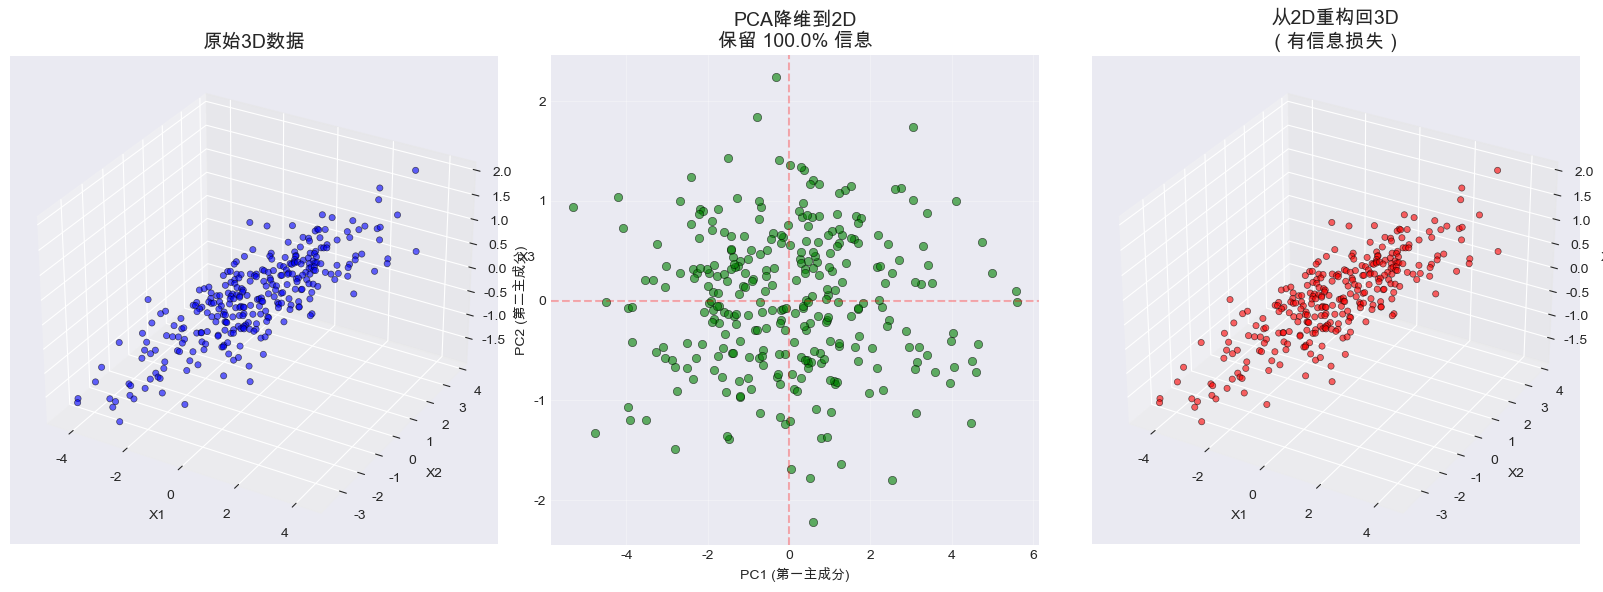


重构误差 (MSE): 0.0000


In [8]:
# 可视化降维前后的数据
fig = plt.figure(figsize=(16, 6))

# 原始3D数据
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c='blue', alpha=0.6, edgecolors='black', linewidth=0.5)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('X3')
ax1.set_title('原始3D数据', fontsize=14, fontweight='bold')

# PCA降维到2D
ax2 = fig.add_subplot(132)
ax2.scatter(X_2d_scratch[:, 0], X_2d_scratch[:, 1], c='green', alpha=0.6, edgecolors='black', linewidth=0.5)
ax2.set_xlabel('PC1 (第一主成分)')
ax2.set_ylabel('PC2 (第二主成分)')
ax2.set_title(f'PCA降维到2D\n保留 {pca_scratch.explained_variance_ratio_.sum()*100:.1f}% 信息', 
             fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.3)
ax2.axvline(x=0, color='r', linestyle='--', alpha=0.3)

# 重构回3D（会有信息损失）
X_reconstructed = pca_scratch.inverse_transform(X_2d_scratch)
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], X_reconstructed[:, 2], 
           c='red', alpha=0.6, edgecolors='black', linewidth=0.5)
ax3.set_xlabel('X1')
ax3.set_ylabel('X2')
ax3.set_zlabel('X3')
ax3.set_title('从2D重构回3D\n（有信息损失）', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 计算重构误差
reconstruction_error = np.mean((X_3d - X_reconstructed) ** 2)
print(f"\n重构误差 (MSE): {reconstruction_error:.4f}")

## 6. 使用 Scikit-learn 的 PCA

在实际应用中，我们使用sklearn的优化版本。

In [9]:
# 使用sklearn的PCA
pca_sklearn = PCA(n_components=2)
X_2d_sklearn = pca_sklearn.fit_transform(X_3d)

print(f"解释方差比: {pca_sklearn.explained_variance_ratio_}")
print(f"累积解释方差比: {pca_sklearn.explained_variance_ratio_.sum():.4f}")
print(f"\n主成分（特征向量）:")
print(pca_sklearn.components_)

# 对比我们的实现和sklearn的实现
print(f"\n\n📊 对比：我们的实现 vs Sklearn")
print(f"解释方差比（我们）:   {pca_scratch.explained_variance_ratio_}")
print(f"解释方差比（sklearn）: {pca_sklearn.explained_variance_ratio_}")
print(f"\n✅ 结果一致！我们的实现是正确的！")

解释方差比: [0.8884145 0.1115855]
累积解释方差比: 1.0000

主成分（特征向量）:
[[-0.73535218 -0.60614003 -0.30307002]
 [-0.67768516  0.65771898  0.32885949]]


📊 对比：我们的实现 vs Sklearn
解释方差比（我们）:   [0.8884145 0.1115855]
解释方差比（sklearn）: [0.8884145 0.1115855]

✅ 结果一致！我们的实现是正确的！


## 7. 确定最优成分数 ⭐⭐⭐

### 7.1 解释方差比分析

**解释方差比 (Explained Variance Ratio)** 告诉我们每个主成分保留了多少信息。

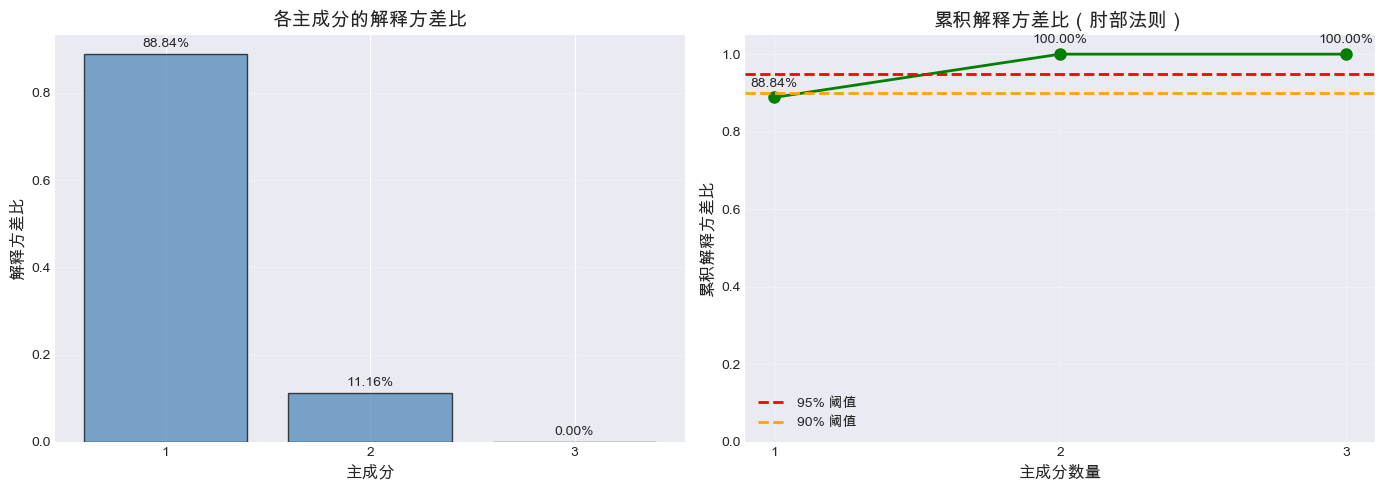


📊 解释方差分析:
  PC1: 88.84% (累积: 88.84%)
  PC2: 11.16% (累积: 100.00%)
  PC3: 0.00% (累积: 100.00%)

💡 选择建议：
  - 保留90%信息：需要 2 个主成分
  - 保留95%信息：需要 2 个主成分


In [10]:
# 计算所有主成分的解释方差比
pca_full = PCA()
pca_full.fit(X_3d)

explained_variance = pca_full.explained_variance_
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：解释方差比
ax1 = axes[0]
n_components = len(explained_variance_ratio)
ax1.bar(range(1, n_components+1), explained_variance_ratio, alpha=0.7, color='steelblue', edgecolor='black')
ax1.set_xlabel('主成分', fontsize=12)
ax1.set_ylabel('解释方差比', fontsize=12)
ax1.set_title('各主成分的解释方差比', fontsize=14, fontweight='bold')
ax1.set_xticks(range(1, n_components+1))
ax1.grid(True, alpha=0.3, axis='y')

# 添加数值标签
for i, v in enumerate(explained_variance_ratio):
    ax1.text(i+1, v+0.01, f'{v:.2%}', ha='center', va='bottom', fontsize=10)

# 右图：累积解释方差比（肘部法则）
ax2 = axes[1]
ax2.plot(range(1, n_components+1), cumulative_variance_ratio, 'o-', linewidth=2, markersize=8, color='green')
ax2.axhline(y=0.95, color='r', linestyle='--', linewidth=2, label='95% 阈值')
ax2.axhline(y=0.90, color='orange', linestyle='--', linewidth=2, label='90% 阈值')
ax2.set_xlabel('主成分数量', fontsize=12)
ax2.set_ylabel('累积解释方差比', fontsize=12)
ax2.set_title('累积解释方差比（肘部法则）', fontsize=14, fontweight='bold')
ax2.set_xticks(range(1, n_components+1))
ax2.set_ylim([0, 1.05])
ax2.legend()
ax2.grid(True, alpha=0.3)

# 添加数值标签
for i, v in enumerate(cumulative_variance_ratio):
    ax2.text(i+1, v+0.02, f'{v:.2%}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n📊 解释方差分析:")
for i in range(n_components):
    print(f"  PC{i+1}: {explained_variance_ratio[i]:.2%} (累积: {cumulative_variance_ratio[i]:.2%})")

print(f"\n💡 选择建议：")
print(f"  - 保留90%信息：需要 {np.argmax(cumulative_variance_ratio >= 0.90) + 1} 个主成分")
print(f"  - 保留95%信息：需要 {np.argmax(cumulative_variance_ratio >= 0.95) + 1} 个主成分")

## 8. 高维数据降维实战 - Digits手写数字

### 8.1 加载数据集

数据形状: (1797, 64)
原始维度: 64D (8x8像素图像)
类别数量: 10
样本数量: 1797


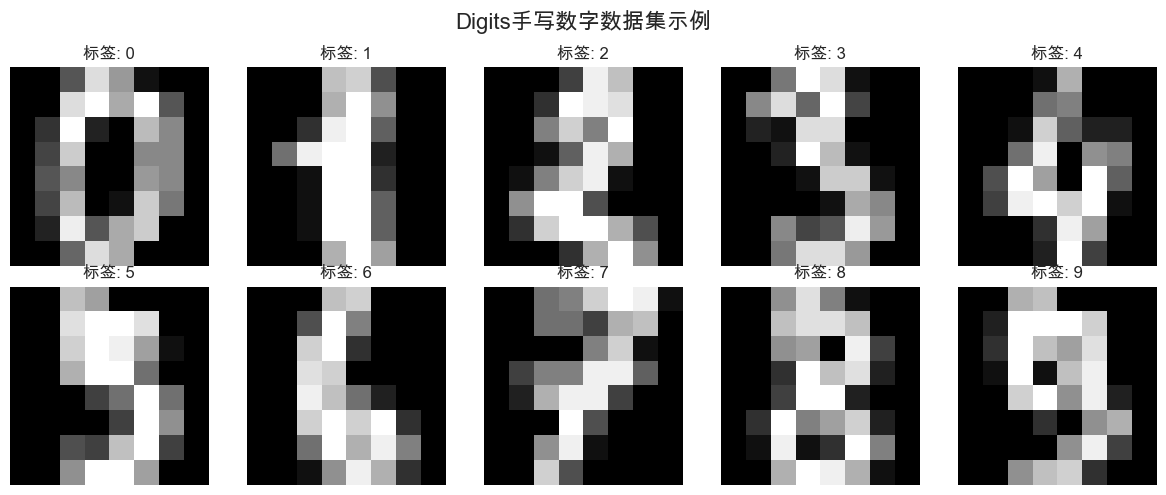

In [11]:
# 加载Digits数据集
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

print(f"数据形状: {X_digits.shape}")
print(f"原始维度: {X_digits.shape[1]}D (8x8像素图像)")
print(f"类别数量: {len(np.unique(y_digits))}")
print(f"样本数量: {len(X_digits)}")

# 可视化一些样本
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(digits.images[i], cmap='gray')
    axes[i].set_title(f'标签: {y_digits[i]}')
    axes[i].axis('off')

plt.suptitle('Digits手写数字数据集示例', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 8.2 使用PCA降维到2D

原始维度: 64D
降维后: 2D

解释方差比: [0.12033916 0.09561054]
累积解释方差比: 0.2159

💡 前2个主成分保留了 21.59% 的信息


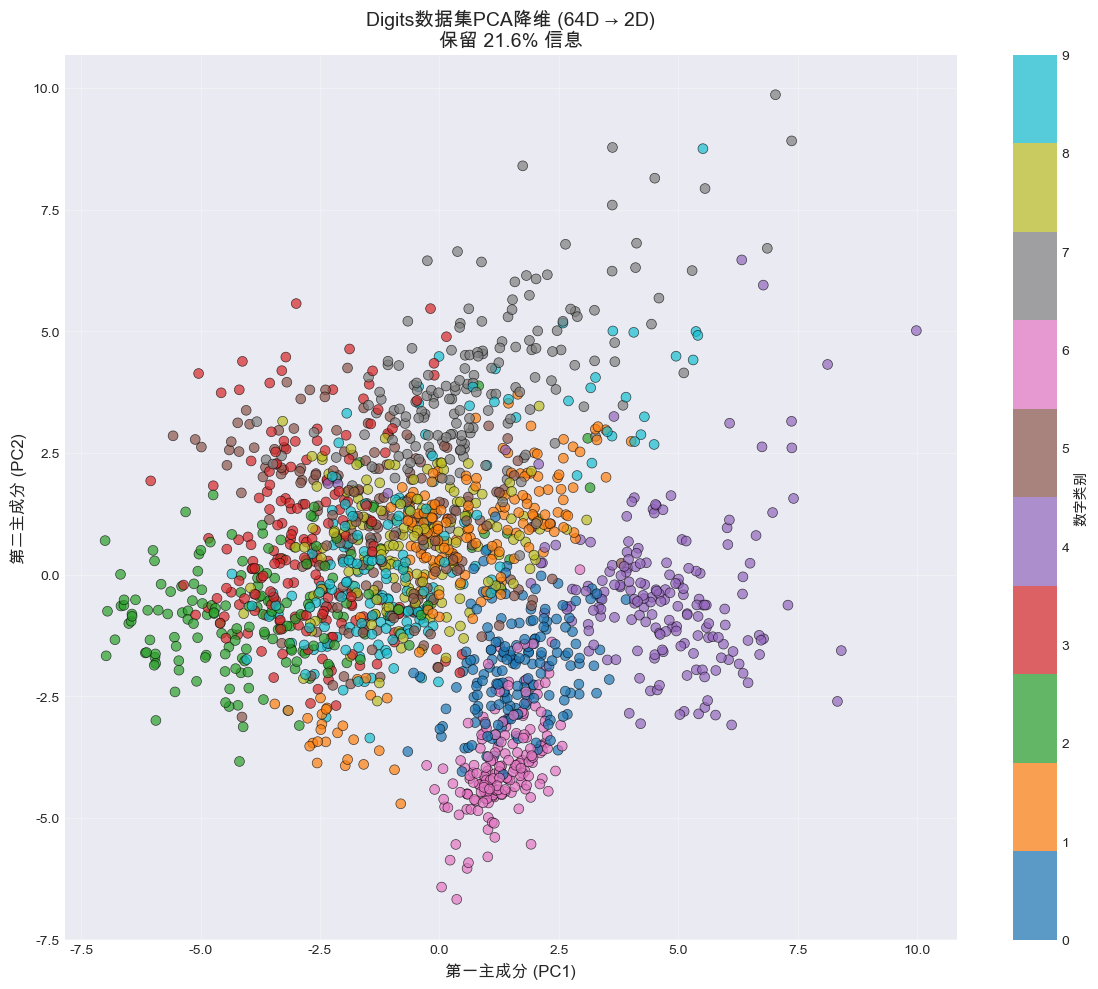


💡 观察：不同数字在2D空间中形成了不同的簇！


In [12]:
# 标准化数据（重要！）
scaler = StandardScaler()
X_digits_scaled = scaler.fit_transform(X_digits)

# PCA降维到2D
pca_digits = PCA(n_components=2)
X_digits_2d = pca_digits.fit_transform(X_digits_scaled)

print(f"原始维度: {X_digits_scaled.shape[1]}D")
print(f"降维后: {X_digits_2d.shape[1]}D")
print(f"\n解释方差比: {pca_digits.explained_variance_ratio_}")
print(f"累积解释方差比: {pca_digits.explained_variance_ratio_.sum():.4f}")
print(f"\n💡 前2个主成分保留了 {pca_digits.explained_variance_ratio_.sum()*100:.2f}% 的信息")

# 可视化降维结果
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_digits_2d[:, 0], X_digits_2d[:, 1], 
                     c=y_digits, cmap='tab10', 
                     s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
plt.xlabel('第一主成分 (PC1)', fontsize=12)
plt.ylabel('第二主成分 (PC2)', fontsize=12)
plt.title(f'Digits数据集PCA降维 (64D → 2D)\n保留 {pca_digits.explained_variance_ratio_.sum()*100:.1f}% 信息', 
         fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='数字类别', ticks=range(10))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 观察：不同数字在2D空间中形成了不同的簇！")

### 8.3 确定Digits数据的最优主成分数

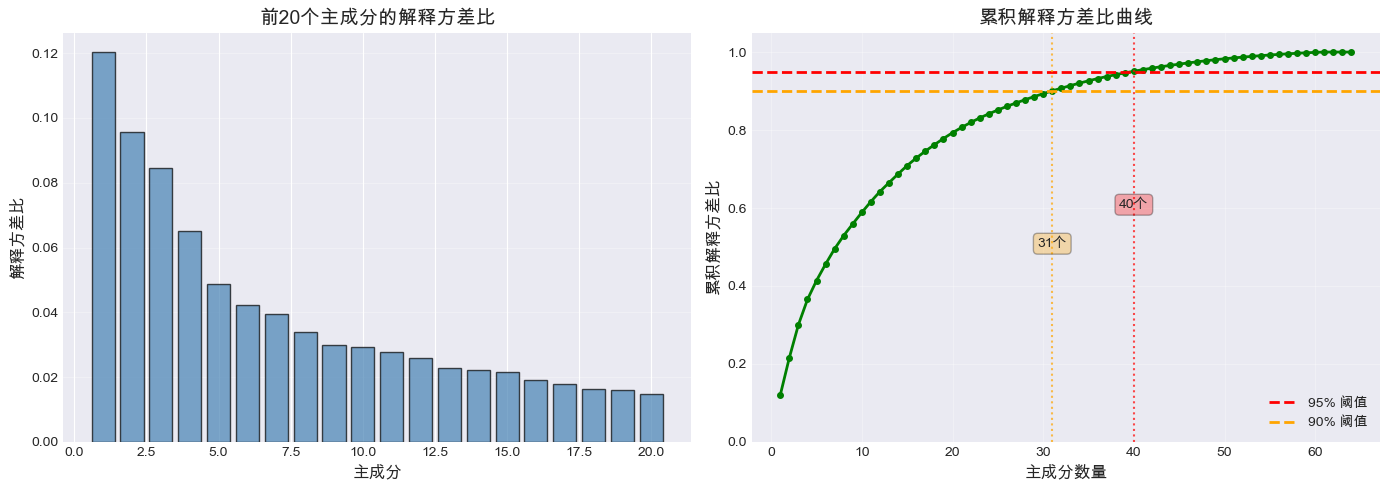


📊 主成分数量建议:
  - 保留90%信息：需要 31 个主成分 (从64维降至31维)
  - 保留95%信息：需要 40 个主成分 (从64维降至40维)
  - 降维率(90%)：51.6%
  - 降维率(95%)：37.5%


In [13]:
# 计算所有64个主成分
pca_digits_full = PCA()
pca_digits_full.fit(X_digits_scaled)

cumulative_variance = np.cumsum(pca_digits_full.explained_variance_ratio_)

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：前20个主成分的解释方差比
ax1 = axes[0]
ax1.bar(range(1, 21), pca_digits_full.explained_variance_ratio_[:20], 
       alpha=0.7, color='steelblue', edgecolor='black')
ax1.set_xlabel('主成分', fontsize=12)
ax1.set_ylabel('解释方差比', fontsize=12)
ax1.set_title('前20个主成分的解释方差比', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# 右图：累积解释方差比
ax2 = axes[1]
ax2.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'o-', 
        linewidth=2, markersize=4, color='green')
ax2.axhline(y=0.95, color='r', linestyle='--', linewidth=2, label='95% 阈值')
ax2.axhline(y=0.90, color='orange', linestyle='--', linewidth=2, label='90% 阈值')

# 标记90%和95%的位置
n_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_95 = np.argmax(cumulative_variance >= 0.95) + 1
ax2.axvline(x=n_90, color='orange', linestyle=':', alpha=0.7)
ax2.axvline(x=n_95, color='r', linestyle=':', alpha=0.7)
ax2.text(n_90, 0.5, f'{n_90}个', ha='center', fontsize=10, 
        bbox=dict(boxstyle='round', facecolor='orange', alpha=0.3))
ax2.text(n_95, 0.6, f'{n_95}个', ha='center', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))

ax2.set_xlabel('主成分数量', fontsize=12)
ax2.set_ylabel('累积解释方差比', fontsize=12)
ax2.set_title('累积解释方差比曲线', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1.05])
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 主成分数量建议:")
print(f"  - 保留90%信息：需要 {n_90} 个主成分 (从64维降至{n_90}维)")
print(f"  - 保留95%信息：需要 {n_95} 个主成分 (从64维降至{n_95}维)")
print(f"  - 降维率(90%)：{(1 - n_90/64)*100:.1f}%")
print(f"  - 降维率(95%)：{(1 - n_95/64)*100:.1f}%")

## 9. Iris数据集案例

### 9.1 PCA降维 + 可视化

数据形状: (150, 4)
特征名称: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
类别名称: ['setosa' 'versicolor' 'virginica']

解释方差比: [0.72962445 0.22850762]
累积解释方差比: 0.9581


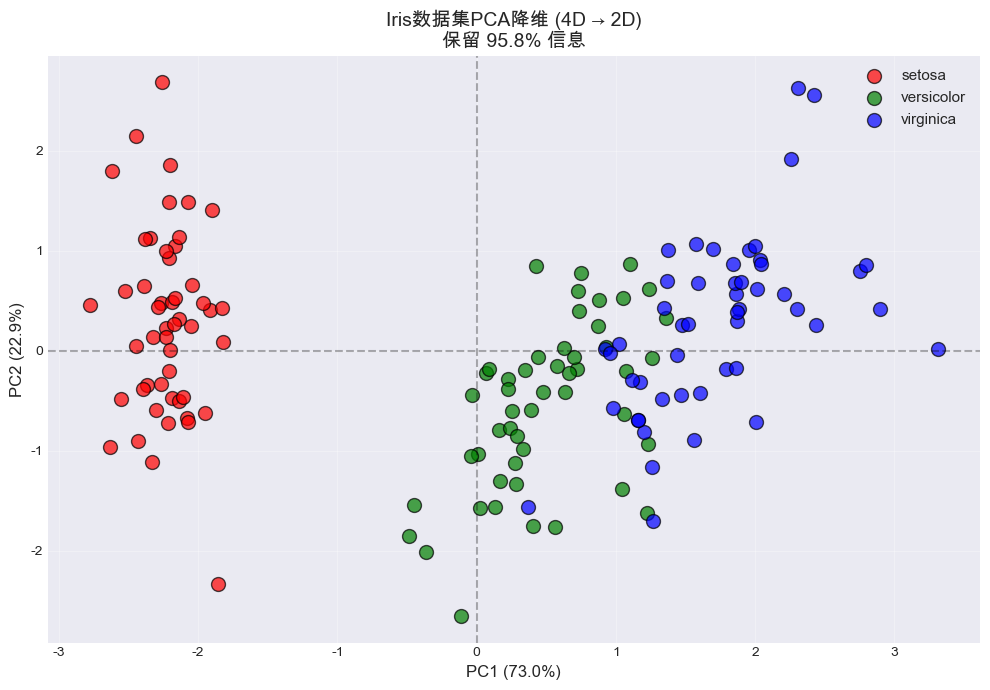


💡 观察：三个类别在2D空间中清晰可分！


In [14]:
# 加载Iris数据集
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
target_names = iris.target_names

print(f"数据形状: {X_iris.shape}")
print(f"特征名称: {iris.feature_names}")
print(f"类别名称: {target_names}")

# 标准化
scaler_iris = StandardScaler()
X_iris_scaled = scaler_iris.fit_transform(X_iris)

# PCA降维到2D
pca_iris = PCA(n_components=2)
X_iris_2d = pca_iris.fit_transform(X_iris_scaled)

print(f"\n解释方差比: {pca_iris.explained_variance_ratio_}")
print(f"累积解释方差比: {pca_iris.explained_variance_ratio_.sum():.4f}")

# 可视化
plt.figure(figsize=(10, 7))
colors = ['red', 'green', 'blue']

for i, (target, color) in enumerate(zip([0, 1, 2], colors)):
    mask = y_iris == target
    plt.scatter(X_iris_2d[mask, 0], X_iris_2d[mask, 1], 
               c=color, label=target_names[target], 
               s=100, alpha=0.7, edgecolors='black', linewidth=1)

plt.xlabel(f'PC1 ({pca_iris.explained_variance_ratio_[0]:.1%})', fontsize=12)
plt.ylabel(f'PC2 ({pca_iris.explained_variance_ratio_[1]:.1%})', fontsize=12)
plt.title(f'Iris数据集PCA降维 (4D → 2D)\n保留 {pca_iris.explained_variance_ratio_.sum()*100:.1f}% 信息', 
         fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 观察：三个类别在2D空间中清晰可分！")

### 9.2 PCA + 聚类

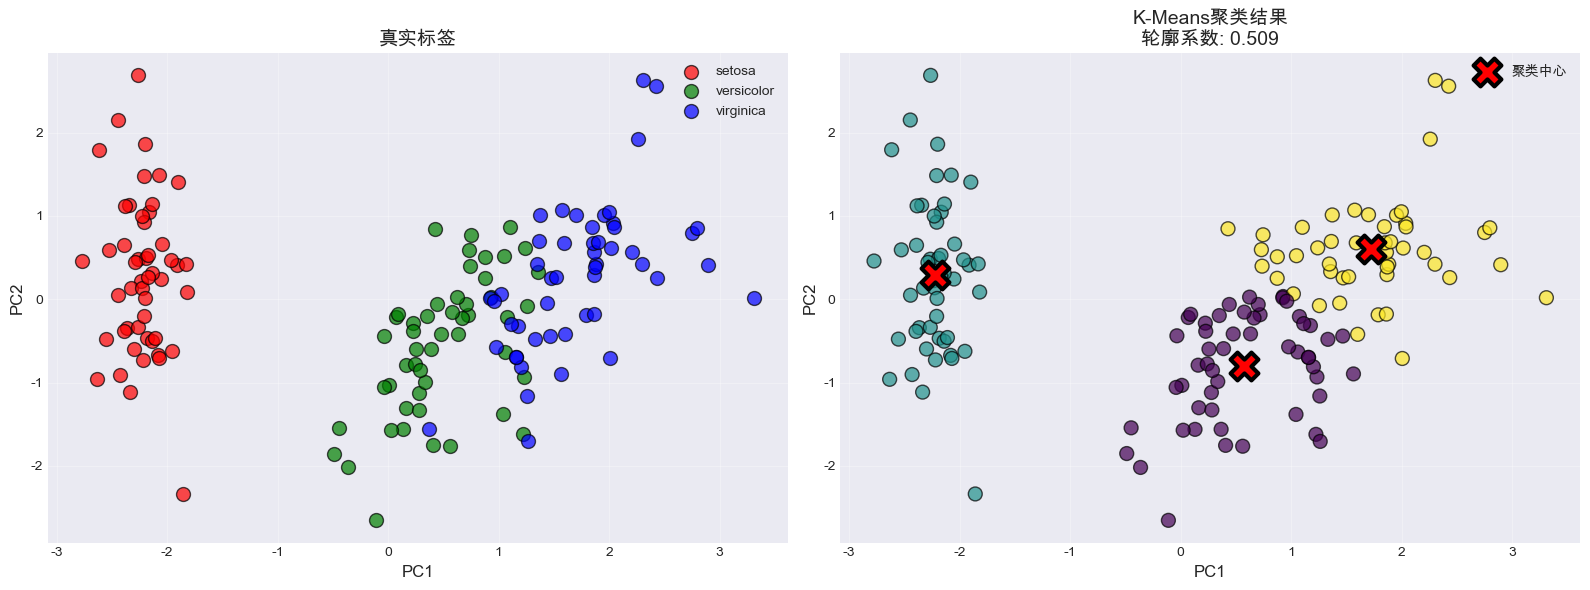


💡 PCA降维后的数据更容易聚类，计算速度也更快！


In [15]:
# 在降维后的数据上进行K-Means聚类
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X_iris_2d)

# 对比真实标签和聚类结果
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 真实标签
ax1 = axes[0]
for i, (target, color) in enumerate(zip([0, 1, 2], colors)):
    mask = y_iris == target
    ax1.scatter(X_iris_2d[mask, 0], X_iris_2d[mask, 1], 
               c=color, label=target_names[target], 
               s=100, alpha=0.7, edgecolors='black', linewidth=1)
ax1.set_xlabel('PC1', fontsize=12)
ax1.set_ylabel('PC2', fontsize=12)
ax1.set_title('真实标签', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# K-Means聚类结果
ax2 = axes[1]
scatter = ax2.scatter(X_iris_2d[:, 0], X_iris_2d[:, 1], 
                     c=y_kmeans, cmap='viridis', 
                     s=100, alpha=0.7, edgecolors='black', linewidth=1)
ax2.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
           c='red', marker='X', s=400, edgecolors='black', linewidths=3, 
           label='聚类中心', zorder=10)
ax2.set_xlabel('PC1', fontsize=12)
ax2.set_ylabel('PC2', fontsize=12)
ax2.set_title(f'K-Means聚类结果\n轮廓系数: {silhouette_score(X_iris_2d, y_kmeans):.3f}', 
             fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 PCA降维后的数据更容易聚类，计算速度也更快！")

## 10. PCA 的优缺点

### ✅ 优点

1. **降低维度**：将高维数据降至低维，便于可视化和分析
2. **去除相关性**：主成分之间正交（不相关）
3. **降噪**：去除方差小的成分，过滤噪声
4. **加速训练**：减少特征数量，提高算法效率
5. **数学严谨**：基于线性代数理论，有明确的数学解释
6. **无监督**：不需要标签信息

### ❌ 缺点

1. **线性假设**：只能捕捉线性关系，对非线性数据效果不好
   - 解决方案：使用核PCA (Kernel PCA)
2. **信息损失**：降维必然损失部分信息
3. **可解释性下降**：主成分是原始特征的线性组合，难以解释
4. **对尺度敏感**：需要先标准化数据
5. **对异常值敏感**：基于方差，容易受异常值影响

### 🎯 适用场景

```python
使用PCA 当:
  ✅ 需要降维可视化
  ✅ 特征数量过多
  ✅ 特征之间高度相关
  ✅ 需要加速训练
  ✅ 数据存在线性相关

不使用PCA 当:
  ⚠️  需要保留所有特征的解释性
  ⚠️  数据维度已经很低
  ⚠️  特征之间不相关
  ⚠️  数据呈现非线性结构
```

### 🔄 PCA 的变体

- **Kernel PCA**：处理非线性数据
- **Incremental PCA**：处理大规模数据
- **Sparse PCA**：产生稀疏主成分

---

## 11. 练习题

### 练习1：理解主成分方向

可视化主成分向量在原始特征空间中的方向。

In [ ]:
# TODO: 你的代码
# 提示：使用pca.components_绘制箭头图，显示主成分方向

### 练习2：PCA用于图像压缩

使用PCA压缩Digits数据集中的图像，观察不同主成分数量对重构质量的影响。

In [ ]:
# TODO: 你的代码
# 提示：
# 1. 使用不同的n_components (如2, 5, 10, 20, 40)
# 2. 重构图像：X_reconstructed = pca.inverse_transform(X_reduced)
# 3. 可视化原始图像和重构图像的对比
# 4. 计算重构误差

### 练习3：PCA + 分类器

对比原始数据和PCA降维后数据在分类任务上的表现。

In [ ]:
# TODO: 你的代码
# 提示：
# 1. 在Iris数据集上使用逻辑回归
# 2. 对比使用原始4D特征 vs PCA降维到2D后的准确率
# 3. 分析结果差异

## 12. 小结

### 🎯 本节要点

1. **PCA原理**：找到数据方差最大的方向作为主成分
2. **算法步骤**：中心化 → 协方差矩阵 → 特征值分解 → 投影
3. **确定成分数**：使用解释方差比，通常保留90-95%的信息
4. **数据预处理**：标准化很重要！
5. **应用场景**：降维可视化、加速训练、去噪、压缩
6. **局限性**：只能处理线性关系、有信息损失

### ✅ 检查清单

- [ ] 理解PCA的数学原理和算法步骤
- [ ] 能从零实现PCA
- [ ] 会使用sklearn.decomposition.PCA
- [ ] 会使用解释方差比确定最优成分数
- [ ] 能够可视化高维数据的降维结果
- [ ] 理解PCA的优缺点和适用场景
- [ ] 完成3个练习题

### 🚀 下一步

继续学习 `05_tsne_umap_visualization.ipynb` - 非线性降维方法（t-SNE和UMAP）

---

**💪 做得好！你已经掌握了PCA降维技术！**